In [206]:
# pretty code automated data analysis tool
#!pip install ydata_profiling &> /dev/null


In [207]:
# keeping track of imports
import seaborn as sns
import numpy as np
import pandas as pd
import sklearn
from  sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import matplotlib.pyplot as plt

Stage 1: Data Pre Processing

- Import the data
- Clean the Data
- Split the Data into training and test sets

before we begin anything, it's best to understand our dataset and exactly what we have here:
- Survival: Binary variable that tells us if the person surivived.
- Pclass: Ticket class (numerical)
- Sex: might be interesting as women and children got on rafts first possibly? (will need to be convered to binary)
- Age: see above about children. (numerical)
- SibSp: # of sibling/ spouses
- parch: Parent to Child Ratio, if child with nanny then 0.
- Cabin: Cabin number (str) might be useful, closer to life raft?
- Embarked: Which port they embarked from (C,Q,S)
- Name might be useful if some sort of status but i doubt it.

In [208]:
# take a look and understand our data
df = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [209]:
df.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [210]:
df.nunique()

PassengerId    891
Survived         2
Pclass           3
Name           891
Sex              2
Age             88
SibSp            7
Parch            7
Ticket         681
Fare           248
Cabin          147
Embarked         3
dtype: int64

The goal of this exercise is to predict survival for each passenger

---



In [211]:
# we can take our training dataset and count all null values, then divide by len of col to have relative NAN %
count_NAN = df.isnull().sum()
percent_NAN =  count_NAN / len(df)
# we can turn this into a data frame as well
NAN_df = pd.DataFrame( {'Variable' : df.columns, 'NaN count' : count_NAN ,'NaN %': round(percent_NAN,4) } )
NAN_df

,Variable,NaN count,NaN %
PassengerId,PassengerId,0,0.0000
Survived,Survived,0,0.0000
Pclass,Pclass,0,0.0000
Name,Name,0,0.0000
Sex,Sex,0,0.0000
Age,Age,177,0.1987
SibSp,SibSp,0,0.0000
Parch,Parch,0,0.0000
Ticket,Ticket,0,0.0000
Fare,Fare,0,0.0000


In [212]:
testcount_NAN = test.isnull().sum()
testpercent_NAN =  testcount_NAN / len(test)
# we can turn this into a data frame as well
NAN_df = pd.DataFrame( {'Variable' : test.columns, 'NaN count' : testcount_NAN ,'NaN %': round(testpercent_NAN,4) } )
NAN_df

,Variable,NaN count,NaN %
PassengerId,PassengerId,0,0.0000
Pclass,Pclass,0,0.0000
Name,Name,0,0.0000
Sex,Sex,0,0.0000
Age,Age,86,0.2057
SibSp,SibSp,0,0.0000
Parch,Parch,0,0.0000
Ticket,Ticket,0,0.0000
Fare,Fare,1,0.0024
Cabin,Cabin,327,0.7823


There are a few ways to fill in missing data:
- Dropping NA values
- Filling value with mean or median (if categorical then mode)
- Regressing on the remaining variables to fill in the missing data. Typically overkill imo (atleast in my very little experience).

For our purposes we will do the latter:

<ipython-input-213-01e379f44439>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  heatmap = sns.heatmap(df.drop('PassengerId', axis = 1).corr(), annot = True)


Text(0.5, 1.0, 'Correlations')

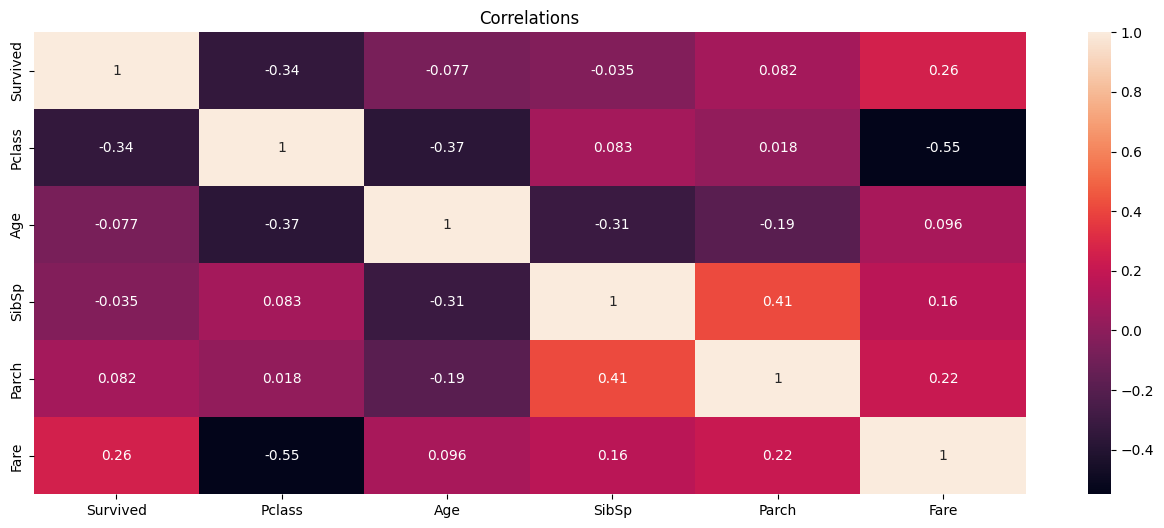

In [213]:
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(df.drop('PassengerId', axis = 1).corr(), annot = True)
heatmap.set_title('Correlations')

So we notice some significant correlations: ( corr > 0.3 or corr < -0.3

- Survived, Pclass and Fare
- Age has correlation with Pclass and SibSp and weaker corr with Parch.
- SibSp and Parch have some stronger correlation (moderate)
-Pclass and Fare have strong correlation
- Fare has weak positive correlation with survival.


Filling in NA values.

In [214]:
df[df['Embarked'].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


Let's try and find some sort of relationships with Embarked and their PClass, Age, Sex or Fare.

<Axes: xlabel='Embarked', ylabel='Fare'>

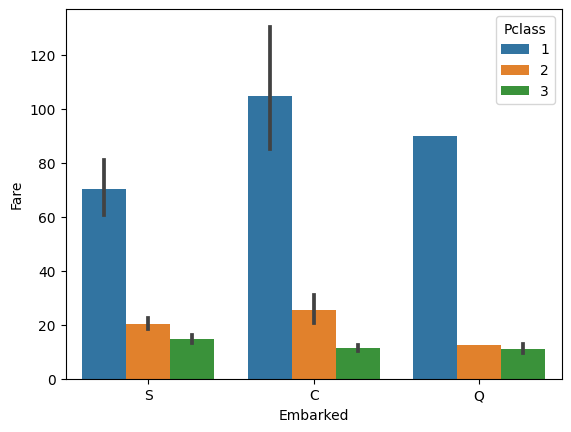

In [215]:
sns.barplot(x = df['Embarked'], y = df['Fare'],  hue = df['Pclass'])

<Axes: xlabel='Pclass', ylabel='Fare'>

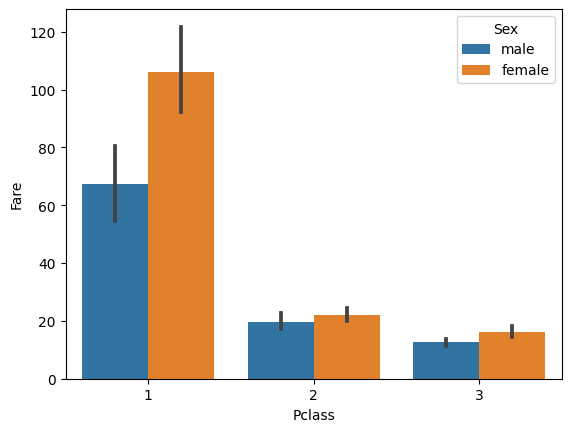

In [216]:
sns.barplot(x = df['Pclass'], y = df['Fare'],  hue = df['Sex'])

<Axes: xlabel='Embarked', ylabel='Fare'>

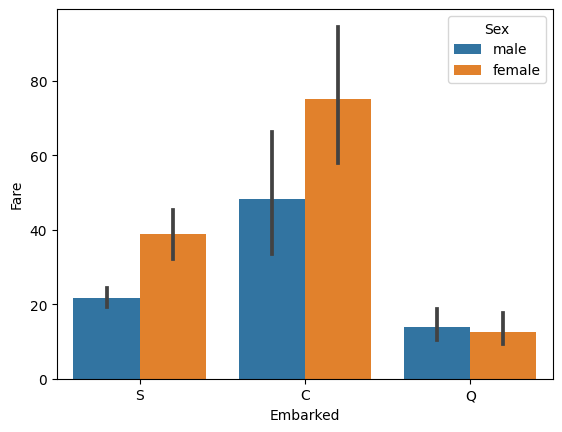

In [217]:
sns.barplot(x = df['Embarked'], y = df['Fare'],  hue = df['Sex'])

Here, we can see there is a relationship. Moreover, that if you are from Pclass 1 and paid a fair of 60-84ish then you would of embarked from S. Let's see if there is some strong correlation or relationships from these three values as we hunched and saw in these bar plots.

Text(0.5, 1.0, 'Correlations')

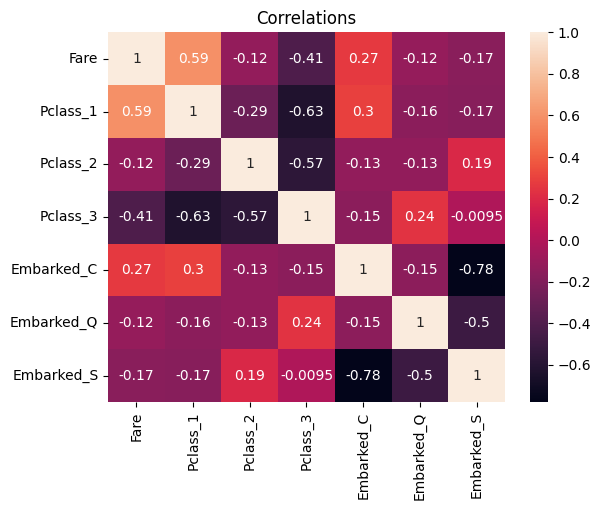

In [218]:
Embarked_Fare_Pclass = df[['Embarked','Fare','Pclass']].copy()
Embarked_Fare_Pclass = pd.get_dummies(Embarked_Fare_Pclass, columns = ['Pclass','Embarked'])
heatmap = sns.heatmap(Embarked_Fare_Pclass.corr(), annot = True)
heatmap.set_title('Correlations')

For now we see will focus on filling the NA values in our training Embarked. Clearly for the fare of 80 with Pclass 1, we believe these two missing values would be filled with S.

In [219]:
df['Embarked'] = df['Embarked'].fillna('S')
df['Embarked'].isnull().sum()

0

Now we want to see if there are any relationships with Age

<Axes: xlabel='Sex', ylabel='Age'>

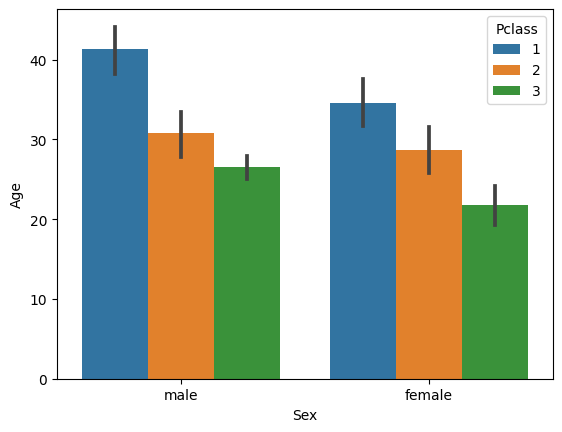

In [220]:
sns.barplot(df, x = 'Sex', y = 'Age', hue = 'Pclass')

We notice that typically Age and Pclass seem to have a negative correlation, higher on Pclass -> older person. Mean age of Males is also higher than females in each Pclass.

The thing that makes the most sense to fill out Age is to group by Pclass and Sex. Then we can consider taking the mean or median to fill in the relative missing Age. To determine whether the mean or median should be used. We may want to consider how symmetrical the distribution is.

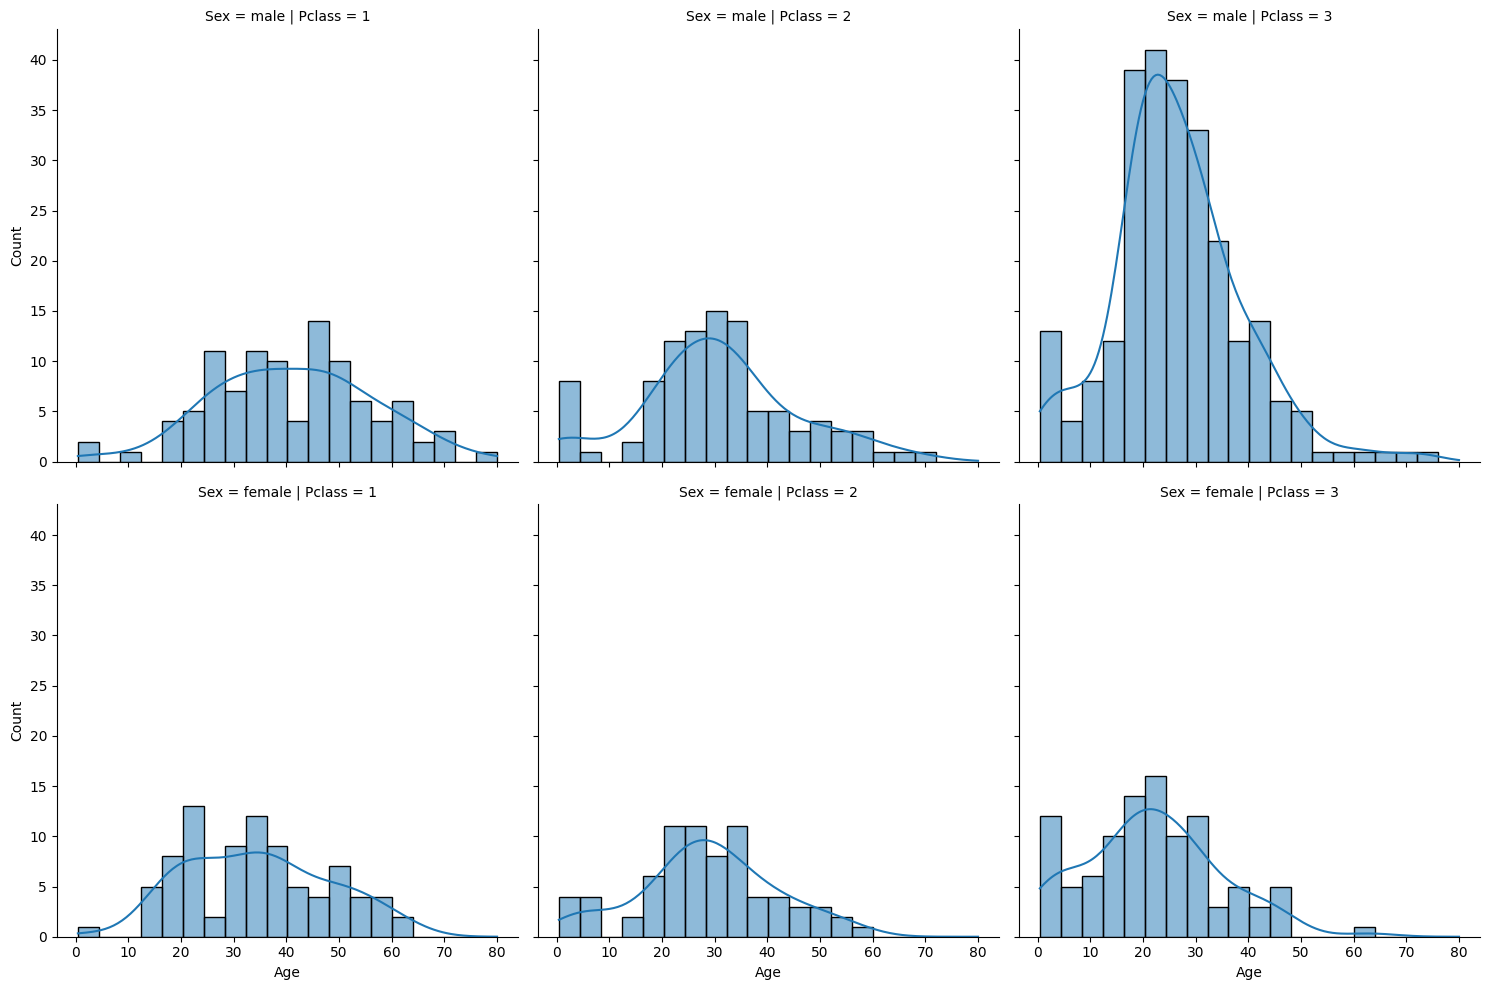

In [221]:
sns.displot(df, x = 'Age', row = 'Sex', col = 'Pclass', kde = True)

Based on the asymmetrical distributions we will proceed with filling in with the Median.

In [222]:
df['Age'] = df.groupby(['Sex', 'Pclass'])['Age'].transform('median')
# we use transform to avoid using a random lambda function. this will fill in with median and bin (deal with outliers)

test['Age'] = test.groupby(['Sex', 'Pclass'])['Age'].transform('median')

For the test dataset, we notice a Fare value is missing and so we can perform some sort of analysis to see how to best fill that in again with probably a facet plot as we saw a relationship with Fare, Pclass and Sex

Bucketing both Age and Fare by Pclass and Sex will allow us to then create bins later which will help deal with outliers.

In [223]:
df['Fare'] = df.groupby(['Pclass','Sex'])['Fare'].transform('median')
test['Fare'] = test.groupby(['Pclass','Sex'])['Fare'].transform('median')

Now we need to deal with Cabin which has the largest number of missing values. Let's see if there are any relationships with the other variables or with survival. Cabin has a unique letter followed by numbers indicating where they were. We need to extract the letter label

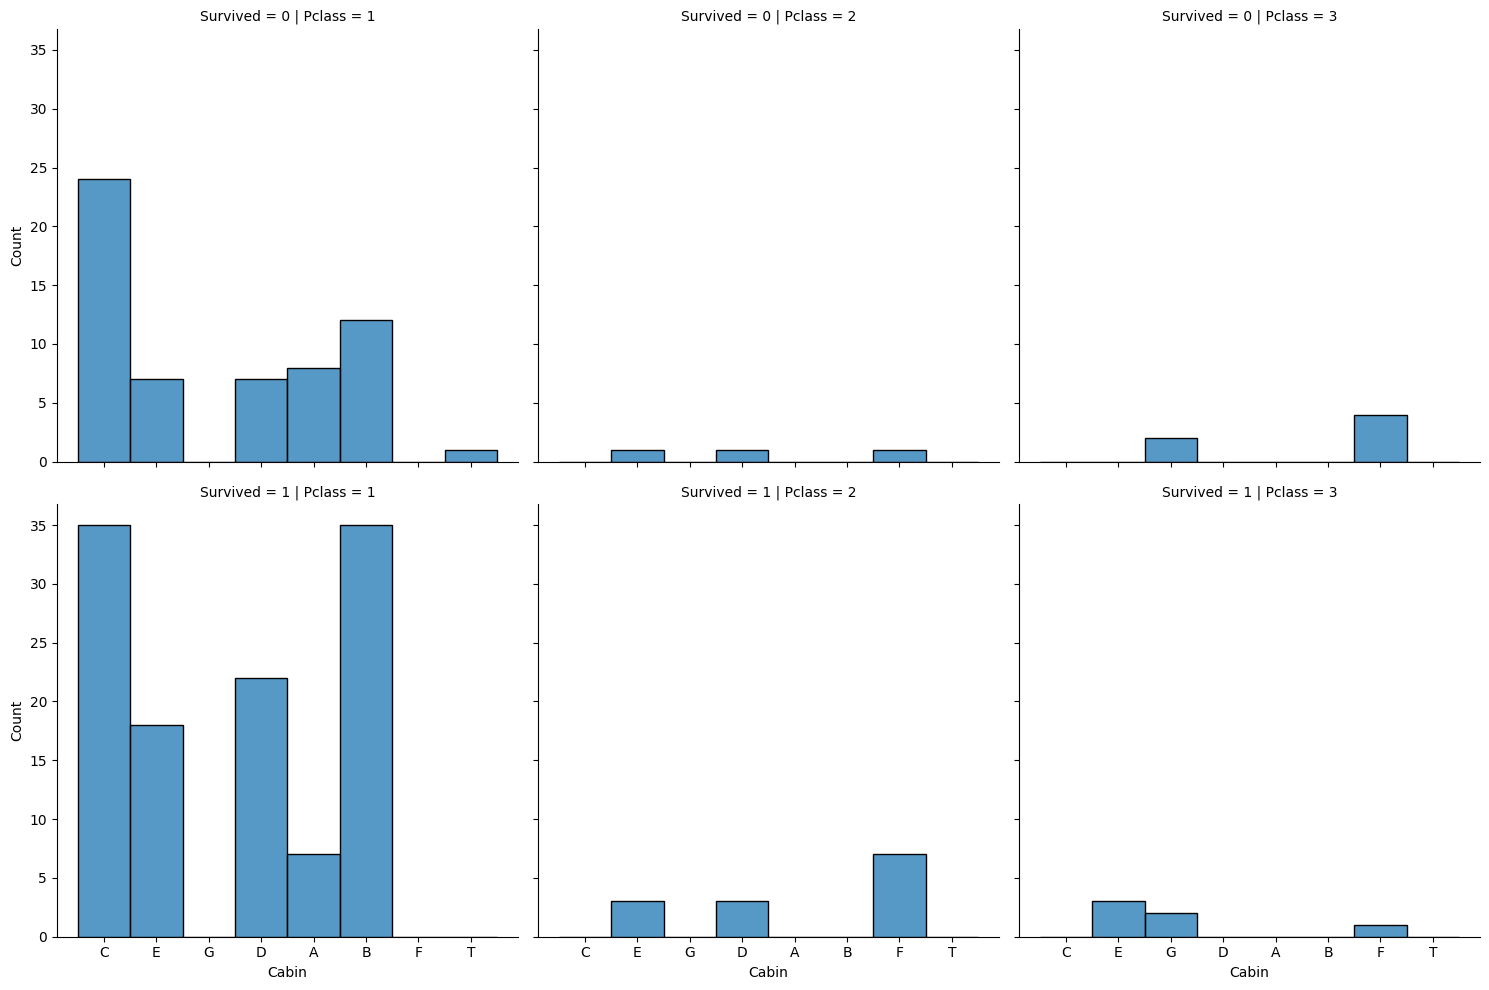

In [224]:
df['Cabin'] = df['Cabin'].str[0]
test['Cabin'] = test['Cabin'].str[0]
sns.displot(x = df['Cabin'], row = df['Survived'],col = df['Pclass'] )

<Axes: xlabel='Cabin', ylabel='Parch'>

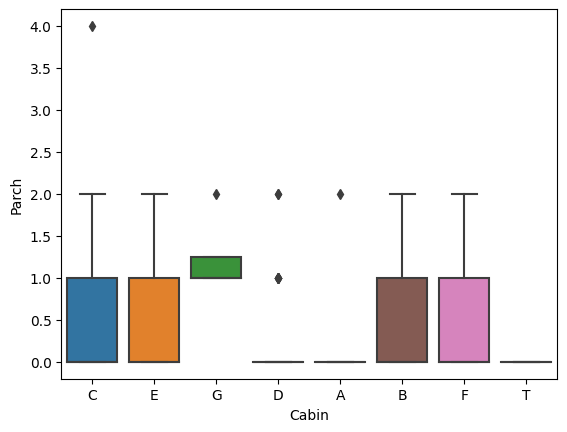

In [225]:
sns.boxplot(df, x = 'Cabin', y = 'Parch')

<Axes: xlabel='Cabin', ylabel='SibSp'>

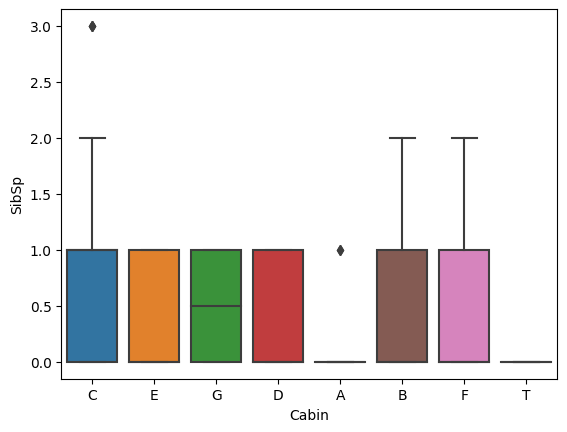

In [226]:
sns.boxplot(df, x = 'Cabin', y = 'SibSp')

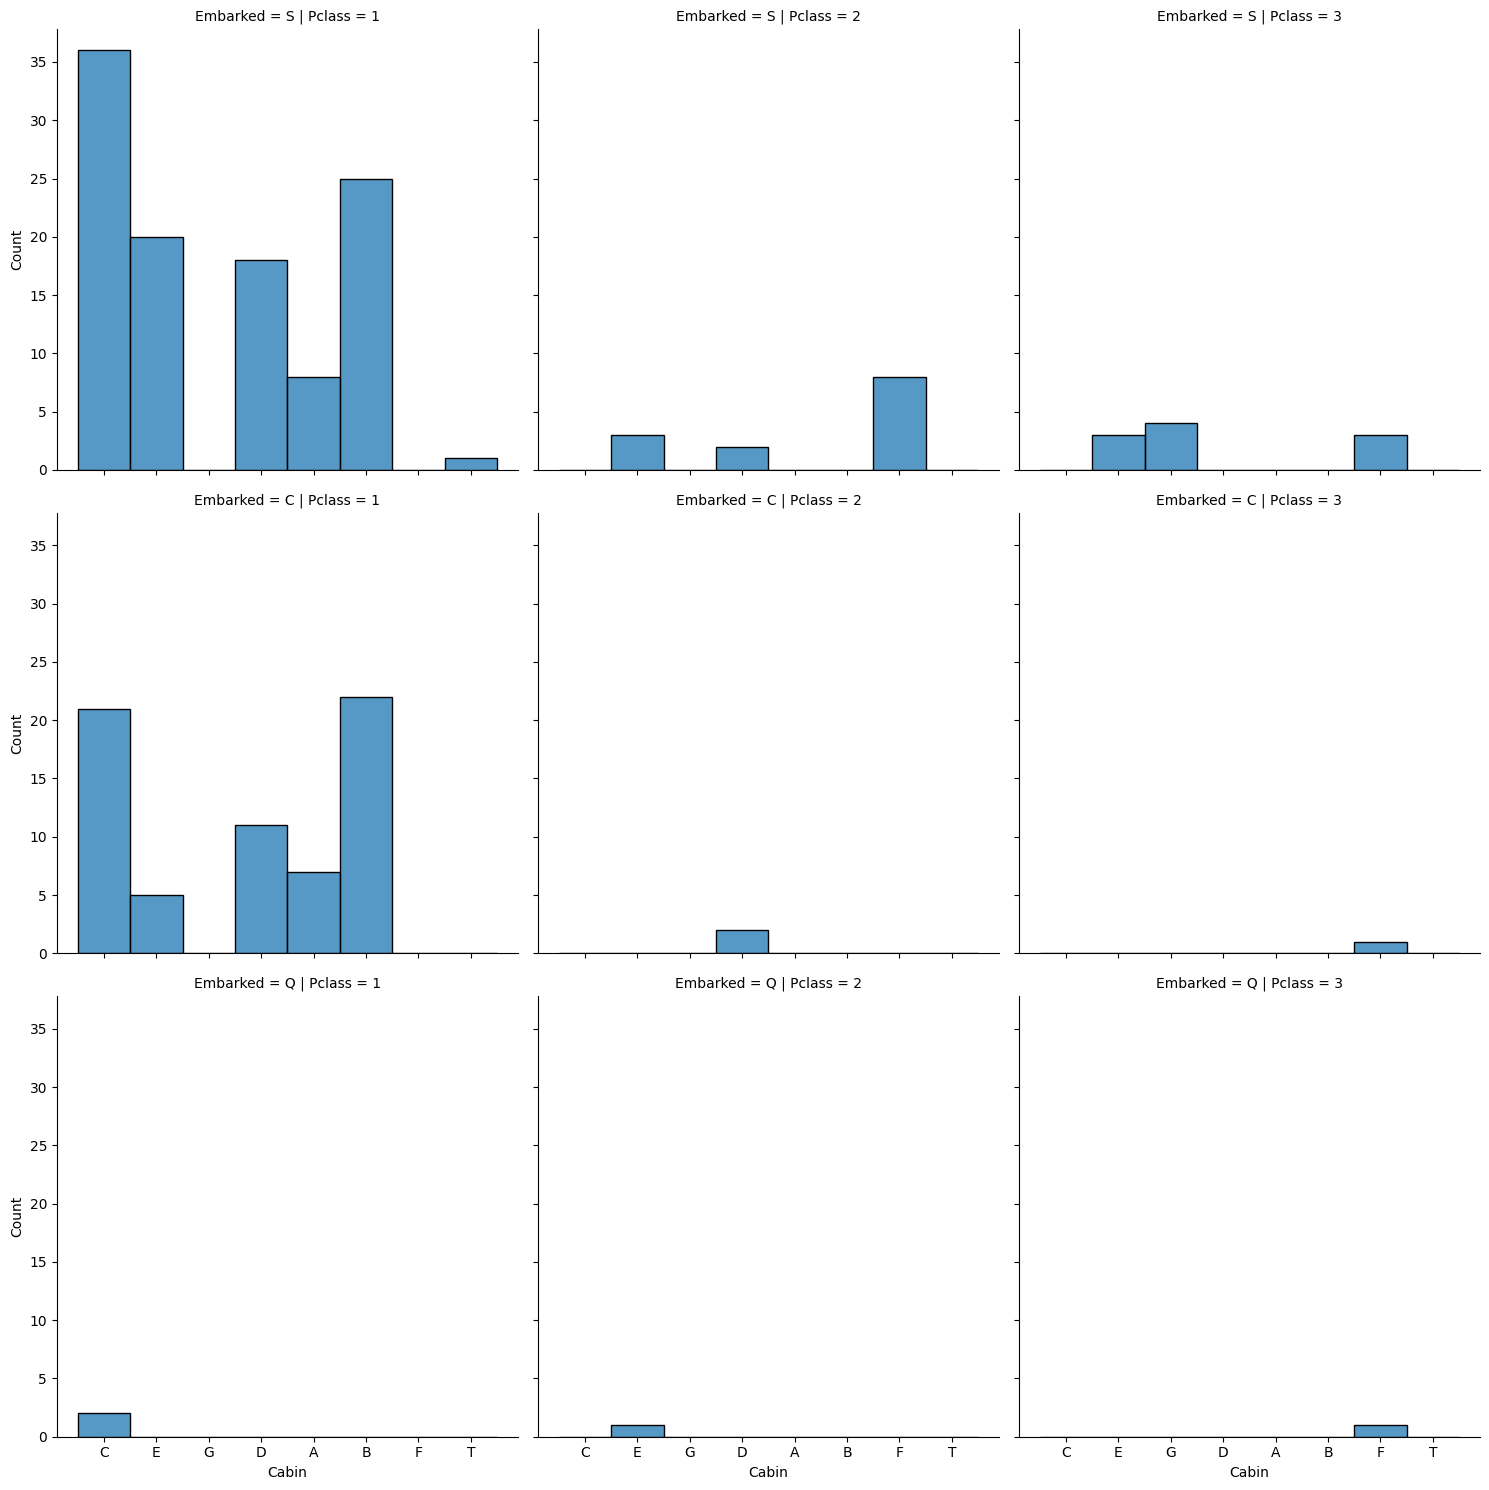

In [227]:
sns.displot(x = df['Cabin'], row = df['Embarked'],col = df['Pclass'] )

It is difficult to see a clear relationship to fill in values. Especially considering majority of them are missing. We consider two choices:
- Fill in NA with an unlabelled new label.
- Fill in with the mode of each local group (by variable).

There is a strong possiblity that the majority who died are under represented here and so I have a strong feeling to create a new unique unlabelled bin called 'U':

In [228]:
df['Cabin'] = df['Cabin'].fillna('U')
test['Cabin'] = test['Cabin'].fillna('U')

<Axes: xlabel='Cabin', ylabel='count'>

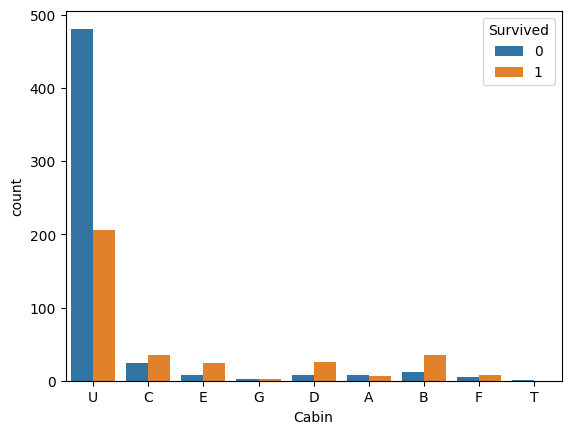

In [229]:
sns.countplot(x = df['Cabin'], hue = df['Survived'])

Okay so we have cleaned the data, before we actually split into our training and testing datasets for model performance. We may want to consider some feature engineering (either creating variables or tuning our current variables more appropriately).

For Ticket, we are actually going to apply a similar treatment. if number or if letter:

In [230]:
def ticket_processing(ticket):
  if ticket[0].isnumeric():
    return 'N'
  else:
    return ticket[0]

In [231]:
df['Ticket'] = df['Ticket'].apply(ticket_processing)
test['Ticket'] = test['Ticket'].apply(ticket_processing)

<Axes: xlabel='Ticket', ylabel='count'>

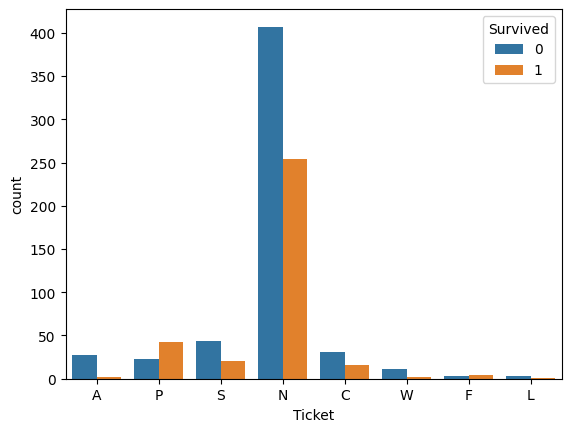

In [232]:
sns.countplot(x = df['Ticket'], hue = df['Survived'])

In [233]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,25.0,1,0,A,7.92500,U,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,35.0,1,0,P,82.66455,C,C
2,3,1,3,"Heikkinen, Miss. Laina",female,21.5,0,0,S,12.47500,U,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,N,82.66455,C,S
4,5,0,3,"Allen, Mr. William Henry",male,25.0,0,0,N,7.92500,U,S


From name, there is a possiblility that Sir name of a person (Mr,Mrs, Master, etc) may affect their survival chance. Actually we know More Females survived vs Males. We can perhaps see some sort of correlation between name and sex. We can also possibly gather more information, higher status sir name -> richer -> better Pclass -> higher survival?

In [234]:
import re
def get_title(name):
  titles = ['Miss', 'Mrs', 'Mr', 'Master', 'Rev', 'Clergy', 'Pastor'] # Mrs before Mr or else Mrs -> Mr by findall
  title = re.findall(r"(?=("+'|'.join(titles)+r"))", name) # https://stackoverflow.com/questions/33406313/how-to-match-any-string-from-a-list-of-strings-in-regular-expressions-in-python
  if title:
    return title[0] # only want the word if exists.

In [235]:
df['Name'] = df['Name'].apply(get_title)
test['Name'] = test['Name'].apply(get_title)

<Axes: xlabel='Ticket', ylabel='count'>

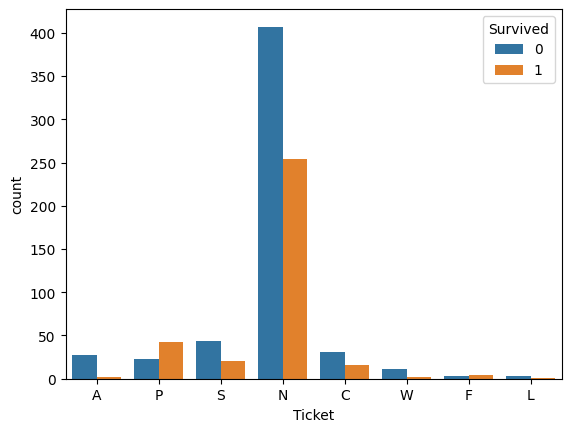

In [236]:
sns.countplot(x = df['Ticket'], hue = df['Survived'])

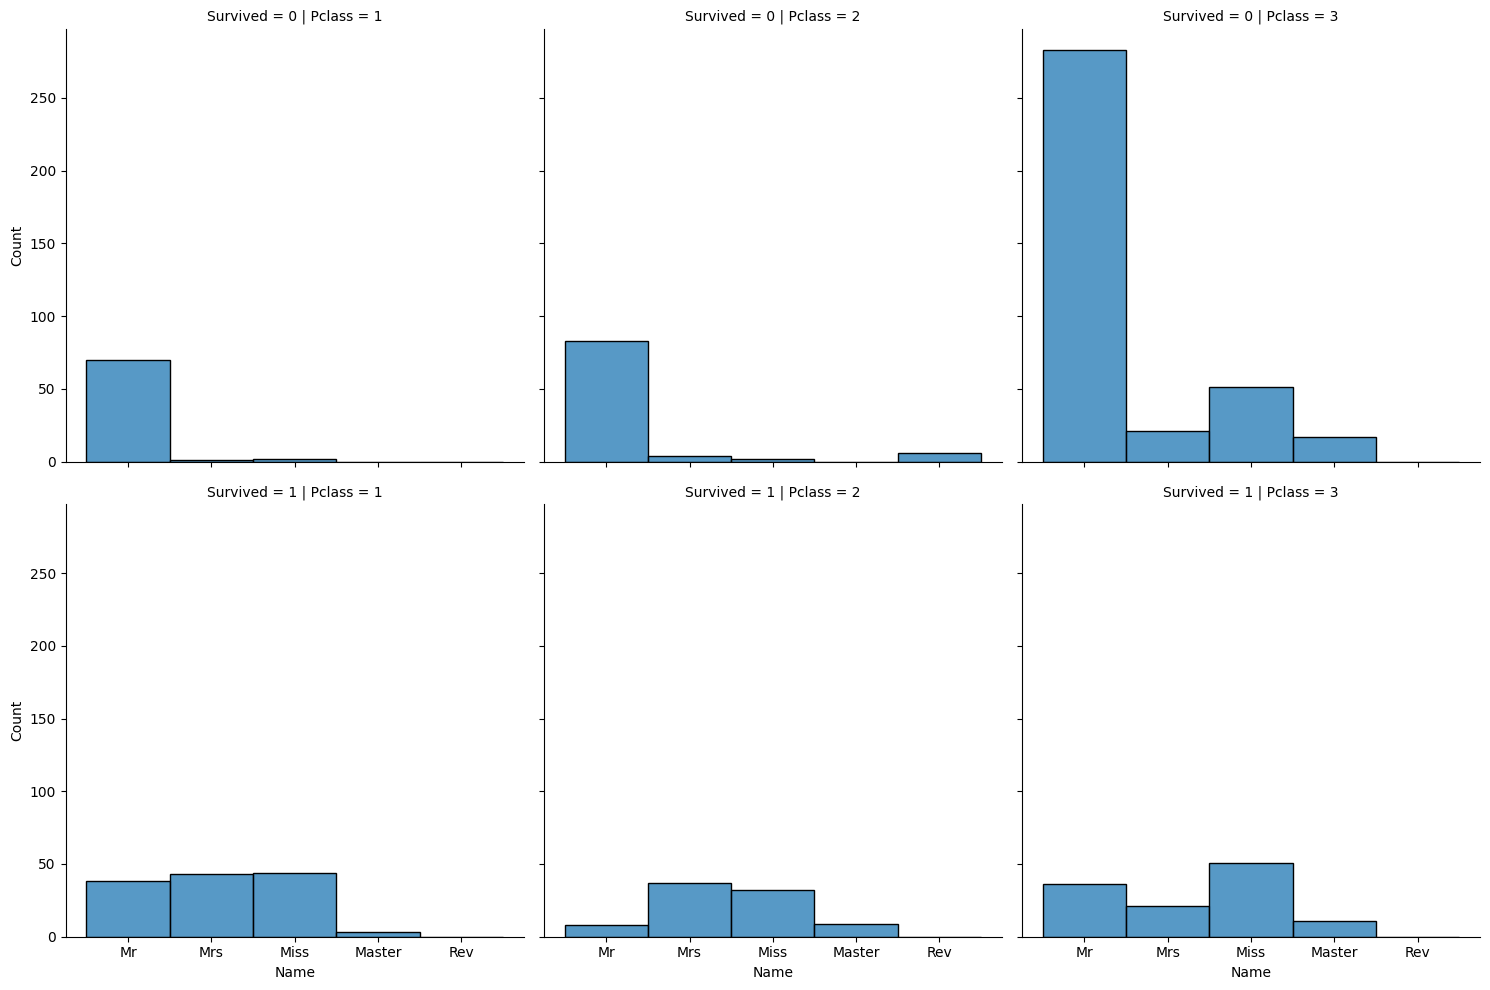

In [237]:
sns.displot(x = df['Name'], col = df['Pclass'], row = df['Survived'])

<Axes: xlabel='Name', ylabel='count'>

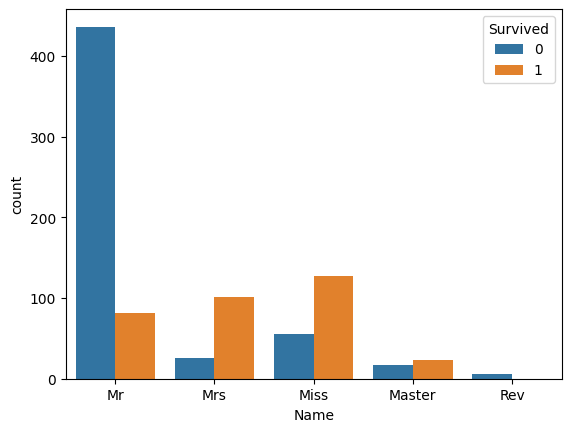

In [238]:
sns.countplot(x = df['Name'], hue = df['Survived'])

For choosing bin sizes we can either decide on the bin size ourselves or use Sturge's rule: $K = 1 + 3.22 log (N)$ where N is number of observations.

Please note:
Sturge’s rule works best for continuous data that is normally distributed and symmetrical. It helps us to convert this data into discrete, symmetric, binomial classes. As long as your data is not skewed, using Sturge’s rule should give you a nice-looking, easy to read histogram that represents the data well. (source: https://www.statisticshowto.com/choose-bin-sizes-statistics/).

Our data is not nice and symmetrical and so we will be creating our own bins.

Now that we have manually performed our analysis and explored different possible relationships. We can try to code this data treatment up a lot cleaner.

First we look at Age:

Age
21.5    144
25.0    347
28.0     76
30.0    108
35.0     94
40.0    122
Name: Age, dtype: int64

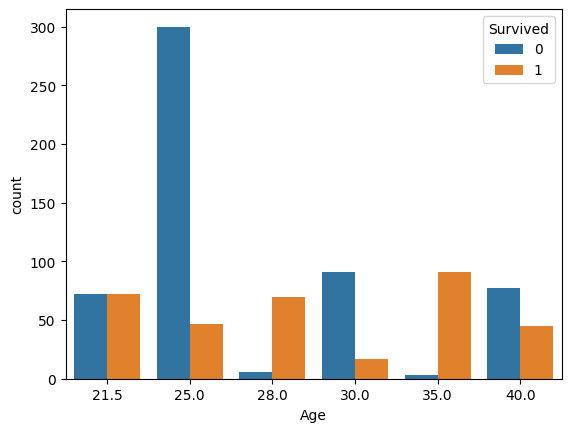

In [239]:
sns.countplot(x = df['Age'], hue = df['Survived'])
df.groupby(['Age'])['Age'].count()

Overall, I am happy with this actually so we will instead now look at Fare

Fare
7.92500     347
12.47500    144
13.00000    108
22.00000     76
41.26250    122
82.66455     94
Name: Fare, dtype: int64

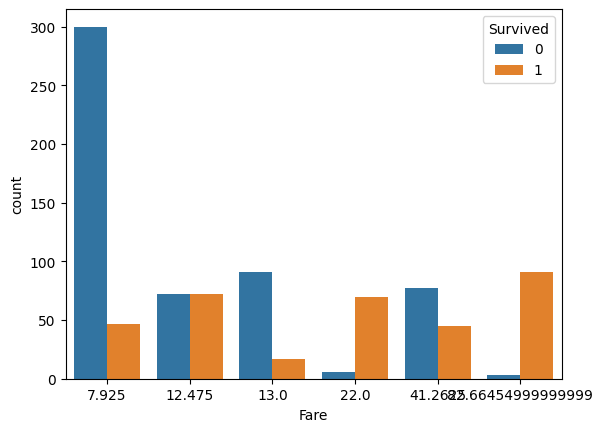

In [240]:
sns.countplot(x = df['Fare'], hue = df['Survived'])
df.groupby(['Fare'])['Fare'].count()

Grouping by median has made our counts pretty decently distributed. There are no bins where the counts are very low.

Ticket
L      4
F      7
W     13
A     29
C     47
P     65
S     65
N    661
Name: Ticket, dtype: int64

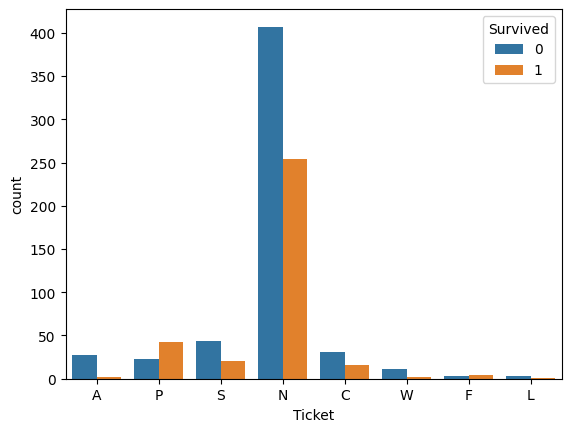

In [241]:
sns.countplot(x = df['Ticket'], hue = df['Survived'])
df.groupby(['Ticket'])['Ticket'].count().sort_values()

Okay so here we see there are some low counts for L,F,W and so lets aggregate them into similar PClasses. We know Pclass has the strongest association with Survived. Below from our plot. Since we want to group by Pclass that S, C, L, W and A could go together. We will throw in F as well since its not significant on its own.

<Axes: xlabel='Ticket', ylabel='count'>

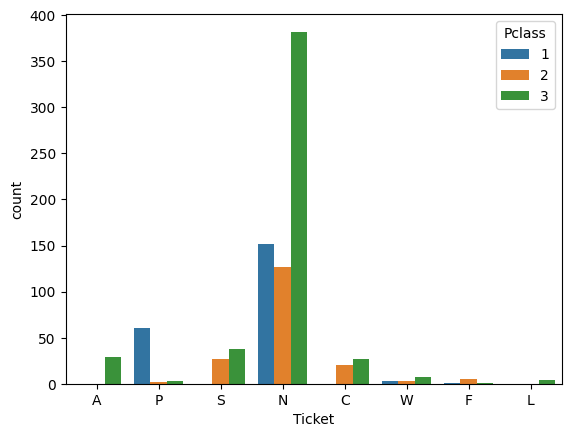

In [242]:
sns.countplot(x = df['Ticket'], hue = df['Pclass'])

In [243]:
def binning_ticket(label):

  # if in the unpopular bins, FOR FUTURE JUST USE LAMBDA FUNCs MAN
  if label in ['A','S','C', 'L','W','F']:
    return 'T'
  else:
    return label

In [244]:
df['Ticket'] = df['Ticket'].apply(binning_ticket)
test['Ticket'] = test['Ticket'].apply(binning_ticket)

<Axes: xlabel='Ticket', ylabel='count'>

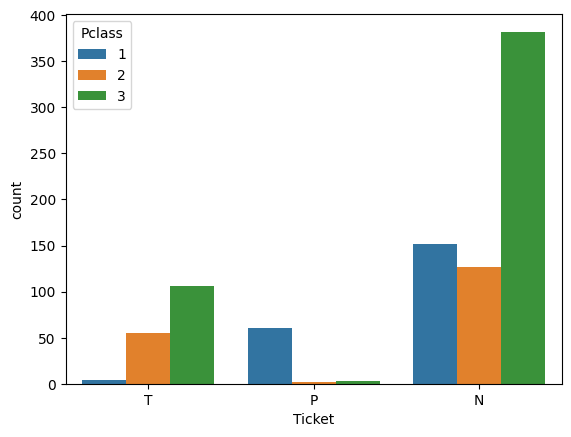

In [245]:
sns.countplot(x = df['Ticket'], hue = df['Pclass'])

<Axes: xlabel='Ticket', ylabel='count'>

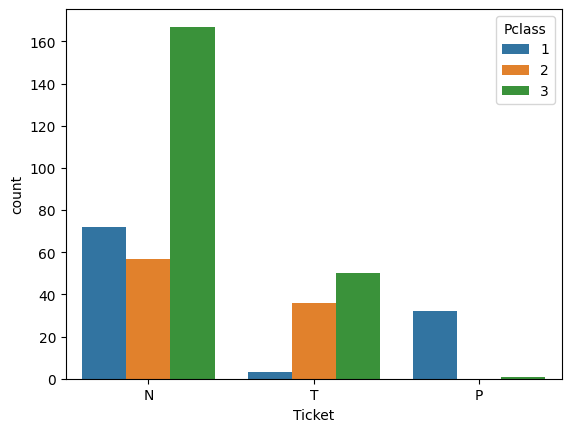

In [246]:
sns.countplot(x = test['Ticket'], hue = test['Pclass'])

I wonder if we could logic our way into suggesting that P tickets might be more related to Pclass and and the other unlabelled tickets could possibly fit into our T bin.... We can actually see similar distributions in the Test set

Text(0.5, 1.0, 'Correlations')

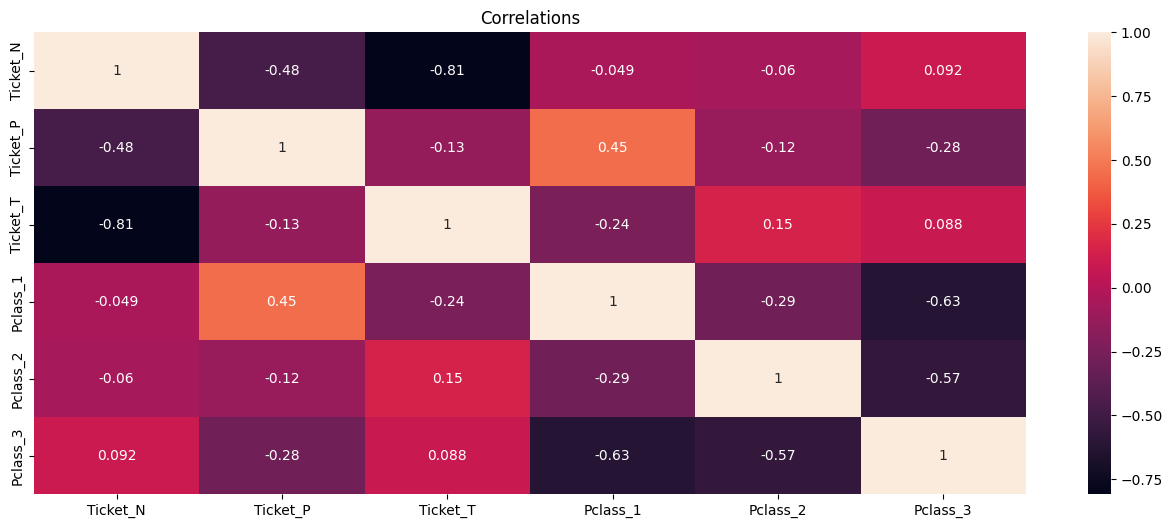

In [247]:
plt.figure(figsize=(16, 6))
Ticket_corr = df[['Ticket','Pclass']]
# need to ont hot label variables so we may compare the relationship with each Pclass
Ticket_corr = pd.get_dummies(Ticket_corr, columns = ['Ticket', 'Pclass'] )
heatmap = sns.heatmap(Ticket_corr.corr(), annot = True)
heatmap.set_title('Correlations')

Okay so we see that Pclass 1  has moderate correlation with Ticket P, We dont really see any strong correlations else where and so we will leave it as so. Now lets deal with Cabin:

<Axes: xlabel='Cabin', ylabel='count'>

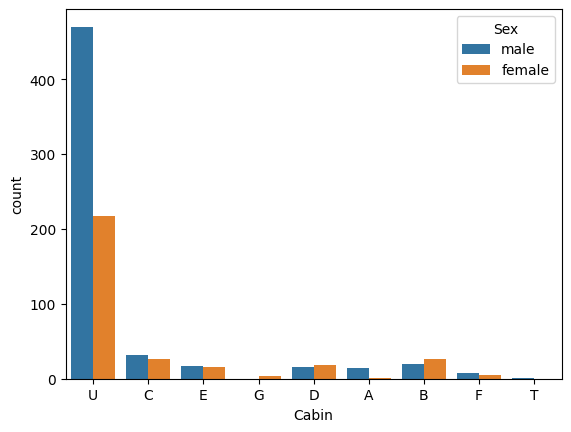

In [248]:
sns.countplot(x = df['Cabin'], hue = df['Sex'])

Cabin
T      1
G      4
F     13
A     15
E     32
D     33
B     47
C     59
U    687
Name: Cabin, dtype: int64

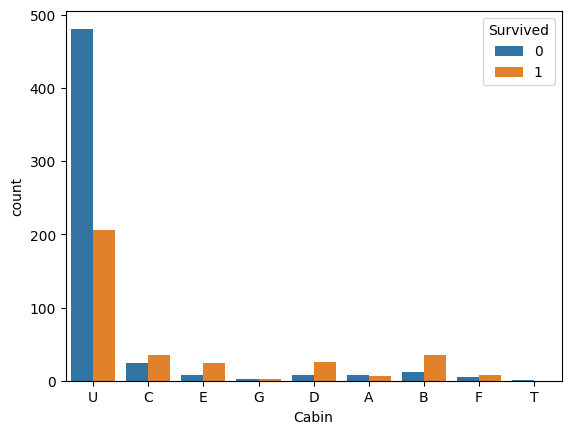

In [249]:
sns.countplot(x = df['Cabin'], hue = df['Survived'])
df.groupby(['Cabin'])['Cabin'].count().sort_values()

<Axes: xlabel='Cabin', ylabel='count'>

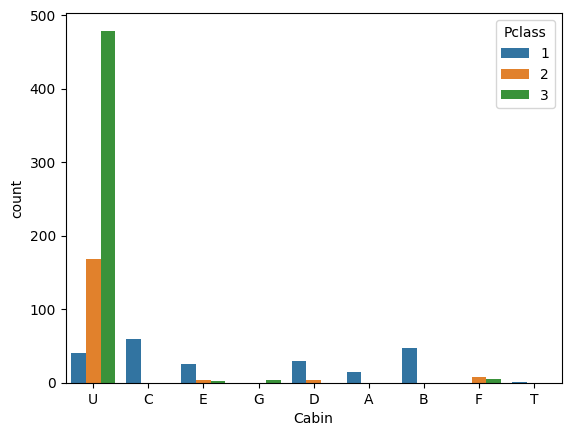

In [250]:
sns.countplot(x = df['Cabin'], hue = df['Pclass'] )

Okay so we notice the cabins with higher survival are the ones containing more PClass 1 people. Perhaps we can group up those Cabin labels. There seems to be a theme such that PClass 1 does much better than Pclass 2 and 3 which may be as strong of an indicator as Sex for Surivival variable.

In [251]:
def binning_cabin(label):

  # if in the unpopular bins, FOR FUTURE JUST USE LAMBDA FUNCs MAN
  if label in ['C', 'E','D','B','A','T']:
    return 'P1'
  elif label == 'U':
    return label
  else:
    return 'P2_P3'

In [252]:
df['Cabin'] = df['Cabin'].apply(binning_cabin)
test['Cabin'] = test['Cabin'].apply(binning_cabin)

<Axes: xlabel='Cabin', ylabel='count'>

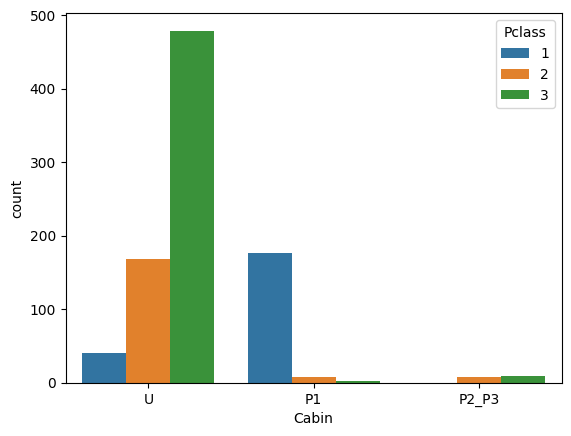

In [253]:
sns.countplot(x = df['Cabin'], hue = df['Pclass'] )

<Axes: xlabel='Cabin', ylabel='count'>

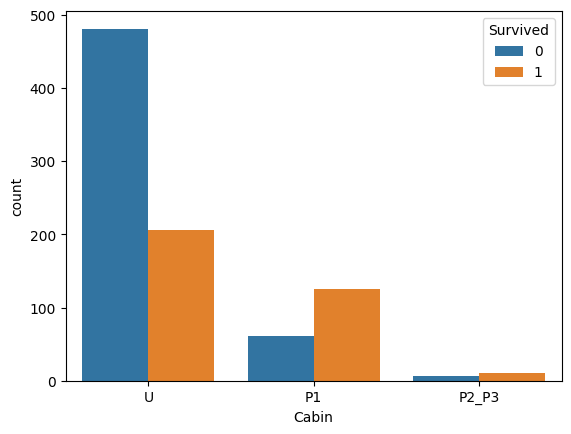

In [254]:
sns.countplot(x = df['Cabin'], hue = df['Survived'] )

Of course I acknowledge that P1 label has some other Pclasses however, it is generally PClass 1, our goal is to bin the cabin folk we think have higher survival chance together. Now we need to address SibSp and Parch which are Sibling to Spouse ratio and Parent to Child Ratios...

SibSp
5      5
8      7
3     16
4     18
2     28
1    209
0    608
Name: SibSp, dtype: int64

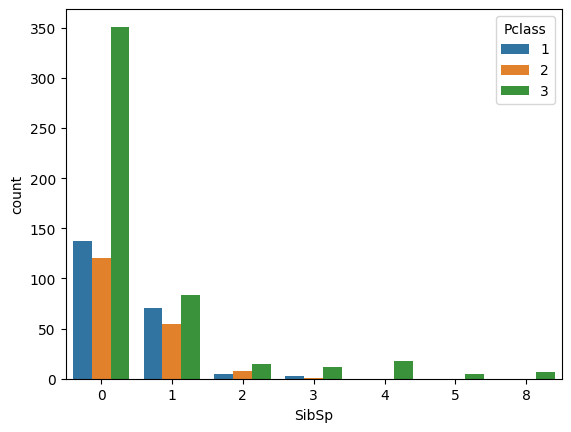

In [255]:
sns.countplot(x = df['SibSp'], hue = df['Pclass'] )
df.groupby(['SibSp'])['SibSp'].count().sort_values()

<Axes: xlabel='SibSp', ylabel='count'>

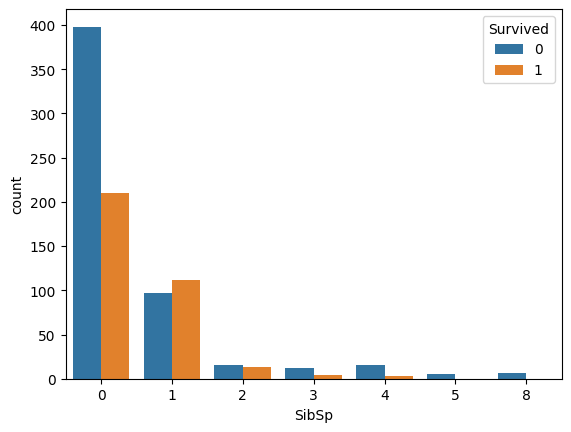

In [256]:
sns.countplot(x = df['SibSp'], hue = df['Survived'] )

In [257]:
def binning_SibSp(label):
  # group into 4 bins, large, med, etc
  if label > 5:
    return 'L'
  elif label > 1:
    return ' M'
  elif label == 1:
    return 'S'
  else:
    return 'N'

In [258]:
df['SibSp'] = df['SibSp'].apply(binning_SibSp)
test['SibSp'] = test['SibSp'].apply(binning_SibSp)

<Axes: xlabel='SibSp', ylabel='count'>

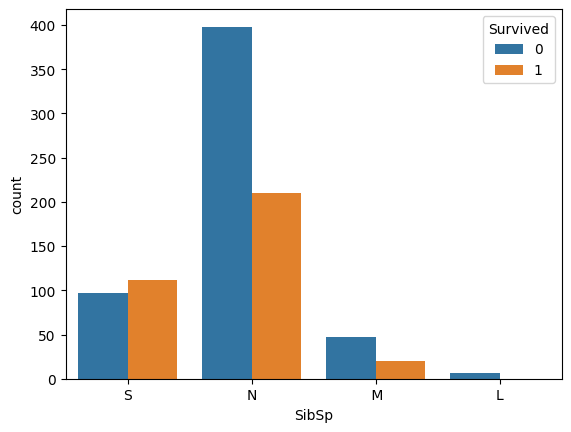

In [259]:
sns.countplot(x = df['SibSp'], hue = df['Survived'] )

<Axes: xlabel='Parch', ylabel='count'>

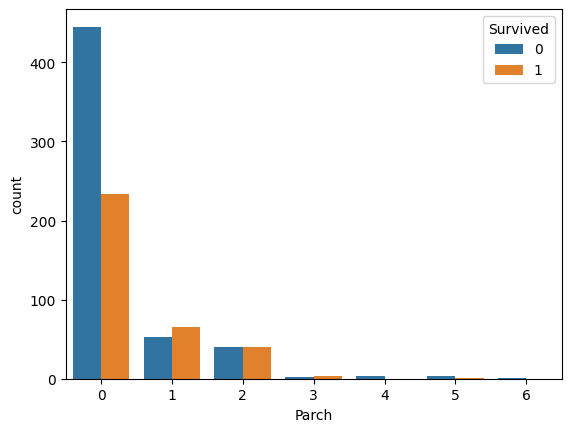

In [260]:
sns.countplot(x = df['Parch'], hue = df['Survived'] )

<Axes: xlabel='Parch', ylabel='count'>

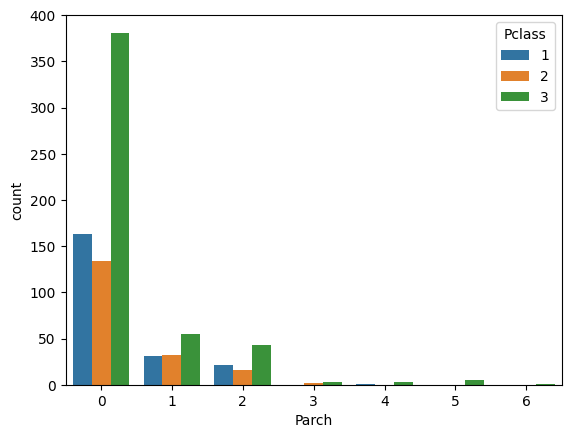

In [261]:
sns.countplot(x = df['Parch'], hue = df['Pclass'] )

In [262]:
def binning_Parch(label):
  # group into 4 bins, large, med, etc
  if label > 5:
    return 'L'
  elif label > 1:
    return ' M'
  elif label == 1:
    return 'S'
  else:
    return 'N'

In [263]:
df['Parch'] = df['Parch'].apply(binning_Parch)
test['Parch'] = test['Parch'].apply(binning_Parch)

<Axes: xlabel='Parch', ylabel='count'>

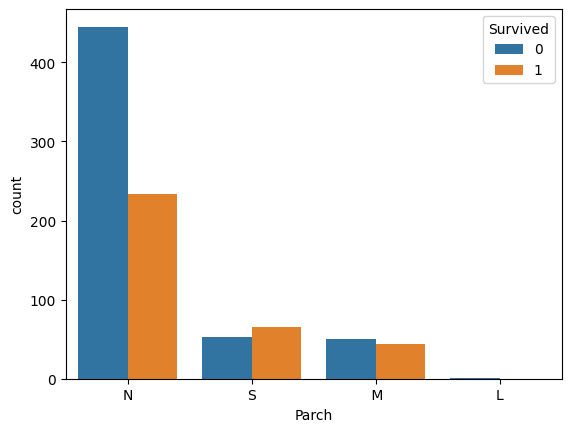

In [264]:
sns.countplot(x = df['Parch'], hue = df['Survived'] )

In [265]:
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,Mr,male,25.0,S,N,T,7.92500,U,S
1,2,1,1,Mrs,female,35.0,S,N,P,82.66455,P1,C
2,3,1,3,Miss,female,21.5,N,N,T,12.47500,U,S
3,4,1,1,Mrs,female,35.0,S,N,N,82.66455,P1,S
4,5,0,3,Mr,male,25.0,N,N,N,7.92500,U,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,Rev,male,30.0,N,N,N,13.00000,U,S
887,888,1,1,Miss,female,35.0,N,N,N,82.66455,P1,S
888,889,0,3,Miss,female,21.5,S,M,T,12.47500,U,S
889,890,1,1,Mr,male,40.0,N,N,N,41.26250,P1,C


Now lets split the data, 1 hot encode variables (categorical data) and move onto the modelling portion

In [266]:
def dataset_splitter(df):
  # drop the ID col as we don't need it
  Y = df['Survived'].drop(columns = ['PassengerId'])
  X = df.drop(columns = ['PassengerId','Survived'])
  X['Sex'] = X['Sex'].astype('category').cat.codes
  return X,Y

In [473]:
X_train , Y_train = dataset_splitter(df)
X_train_alt = X_train
X_train = pd.get_dummies(X_train, columns = ['Name', 'SibSp','Parch','Ticket', 'Cabin', 'Embarked'])

As an alternative, we had a lot of NA in cabin and so we consider a dataset with no Cabin

In [474]:
#X_train_alt = X_train.drop(['Cabin'],axis = 1)
X_train_alt = pd.get_dummies(X_train_alt.drop('Cabin', axis = 1), columns = ['Name', 'SibSp','Parch','Ticket', 'Embarked'])

In [475]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
scalar = StandardScaler()
scalar.fit(X_train)
X_train = scalar.transform(X_train)
X_train_train,X_train_test, Y_train_train , Y_train_test = train_test_split(X_train, Y_train)

In [476]:
scalar.fit(X_train_alt)
X_train_alt = scalar.transform(X_train_alt)

In [477]:
X_test = test
X_test = X_test.drop(columns = ['PassengerId'])
X_test_alt = X_test.drop(columns = ['Cabin'])
X_test['Sex'] = X_test['Sex'].astype('category').cat.codes
X_test = pd.get_dummies(X_test, columns = ['Name', 'SibSp','Parch','Ticket', 'Cabin', 'Embarked', ])

In [478]:
X_test_alt['Sex'] = X_test_alt['Sex'].astype('category').cat.codes
X_test_alt = pd.get_dummies(X_test_alt, columns = ['Name', 'SibSp','Parch','Ticket', 'Embarked'])

In [479]:
scalar.fit(X_test)
X_test = scalar.transform(X_test)

In [480]:
scalar.fit(X_test_alt)
X_test_alt = scalar.transform(X_test_alt)

Due to the high dimensionality (from 1 hot encoding) we will throw a random forest classifier model at it. Alternative approaches may include:
- WOE binning -> Logisitic Regression
- XGBoost
- NN

Step 2: Modelling
- Build the Model
- Train the Model
- Make Predictions


In [481]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

Hyper parameter tuning

In [503]:
n_estimators = [5,20,40,80,100]
max_features = ['auto', 'sqrt']
max_depth =  [2,4,8,10,20]
min_sample_split =  [2,4,5,6]
min_sample_leaf = [1,2,5]
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators, 'max_features': max_features, "max_depth": max_depth, 'min_samples_split': min_sample_split, 'min_samples_leaf' : min_sample_leaf, 'bootstrap': bootstrap}

from sklearn.model_selection import GridSearchCV
rfc_gridsearch = RandomForestClassifier()
rfc_gridsearch = GridSearchCV(estimator = rfc_gridsearch, param_grid = random_grid,cv =4, verbose = 4 , n_jobs = 4 )
rfc_gridsearch.fit(X_train, Y_train)


Fitting 4 folds for each of 1200 candidates, totalling 4800 fits


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


GridSearchCV(cv=4, estimator=RandomForestClassifier(), n_jobs=4,
             param_grid={'bootstrap': [True, False],
                         'max_depth': [2, 4, 8, 10, 20],
                         'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [1, 2, 5],
                         'min_samples_split': [2, 4, 5, 6],
                         'n_estimators': [5, 20, 40, 80, 100]},
             verbose=4)

In [505]:
rfc_gridsearch.best_params_

{'bootstrap': True,
 'max_depth': 8,
 'max_features': 'auto',
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 5}

Step 3: Evaluation
- Calculate performance metrics
- Make a verdict

In [506]:
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
#best_RFC = RandomForestClassifier(bootstrap= True,max_depth= 8,max_features= 'sqrt',min_samples_leaf= 5,min_samples_split= 6, n_estimators= 20)
best_RFC = RandomForestClassifier(**rfc_gridsearch.best_params_)
best_RFC = best_RFC.fit(X_train_train,Y_train_train)
y_pred = best_RFC.predict(X_train_train)
AR_train = accuracy_score(Y_train_train, y_pred)
AR_train

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


0.8473053892215568

In [507]:
roc_auc_score(Y_train_train, best_RFC.predict_proba(X_train_train)[:,1])

0.9011799832112332

In [508]:
y_pred = best_RFC.predict(X_train_test)
AR_test = accuracy_score(Y_train_test, y_pred)
AR_test

0.820627802690583

In [509]:
confusion_matrix(Y_train_test, y_pred)

array([[118,  15],
       [ 25,  65]])

In [510]:
# no cabin data
best_RFC_alt = RandomForestClassifier(**rfc_gridsearch.best_params_)
best_RFC_alt = best_RFC_alt.fit(X_train_alt, Y_train)
y_pred = best_RFC_alt.predict(X_train_alt)
AR_train = accuracy_score(Y_train, y_pred)
AR_train

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


0.8439955106621774

This model is actually pretty good with consistent performance (little change in accuracy ratio) between training and testing datasets.

XGBOOOOOOOOOOOOOOOOOOOOOOOOOOOST

In [494]:
from sklearn.ensemble import GradientBoostingClassifier

xgb = GradientBoostingClassifier(learning_rate=0.1, min_samples_split=500,min_samples_leaf=50,max_depth=8,max_features='sqrt',subsample=0.8,random_state=10)
xgb = xgb.fit(X_train_train, Y_train_train)
y_pred = xgb.predict(X_train_train)
AR_train = accuracy_score(Y_train_train, y_pred)
AR_train

0.8203592814371258

In [524]:
y_pred = xgb.predict(X_train_test)
AR_train = accuracy_score(Y_train_test, y_pred)
AR_train

0.8475336322869955

Hyperparameter tuning

In [504]:
parameters = {
    "n_estimators":[5,50,100,200],
    "max_depth":[1,3,5,7,9],
    "learning_rate":[0.01,0.05,0.1,0.2,0.5]
}
xgb_gs = GradientBoostingClassifier()
gs = GridSearchCV(xgb_gs,parameters,cv=5)
gs.fit(X_train,Y_train)

GridSearchCV(cv=5, estimator=GradientBoostingClassifier(),
             param_grid={'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.5],
                         'max_depth': [1, 3, 5, 7, 9],
                         'n_estimators': [5, 50, 100, 200]})

In [525]:
gs.best_params_

{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50}

In [526]:
xgb = GradientBoostingClassifier(**gs.best_params_)

In [527]:
xgb = xgb.fit(X_train_train, Y_train_train)
y_pred = xgb.predict(X_train_train)
AR_train = accuracy_score(Y_train_train, y_pred)
AR_train

0.8532934131736527

In [529]:
confusion_matrix(Y_train_train, y_pred)

array([[399,  17],
       [ 81, 171]])

In [530]:
y_pred = xgb.predict(X_train_test)
AR_train = accuracy_score(Y_train_test, y_pred)
AR_train

0.8251121076233184

In [531]:
confusion_matrix(Y_train_test, y_pred)

array([[122,  11],
       [ 28,  62]])

Performance seems a bit better but overall similar performance

Submission to Kaggle

re-train best model(s) on whole data

In [535]:
#best_RFC = RandomForestClassifier(bootstrap= True,max_depth= 8,max_features= 'sqrt',min_samples_leaf= 5,min_samples_split= 6, n_estimators= 20)
best_RFC = RandomForestClassifier(**rfc_gridsearch.best_params_)
best_RFC = best_RFC.fit(X_train,Y_train)
y_pred = best_RFC.predict(X_train)
AR = accuracy_score(Y_train, y_pred)
AR

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


0.8473625140291807

In [536]:
xgb = xgb.fit(X_train, Y_train)
y_pred = xgb.predict(X_train)
AR_train = accuracy_score(Y_train, y_pred)
AR_train

0.8484848484848485

In [519]:
#y_test_pred = best_RFC.predict(X_test) # scored 0.79186
y_test_pred_xgb = xgb.predict(X_test)  # scored 0.77272

In [522]:
sub_df = pd.DataFrame({'PassengerID':test['PassengerId'].values, 'Survived':y_test_pred})
sub_df.head()

,PassengerID,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0


In [523]:
from google.colab import files
sub_df.to_csv("submission.csv", index = False)
files.download('submission.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Overall, our best model was the tuned Random Forest Classifier which beat the XGB Classifier model. Not fully a surprise as XGB did better on our training dataset due to possible overfitting and worse performance in the test submission.